# Ensemble Model Training and Test

In [1]:
import pickle
import pandas as pd
import numpy as np
import re
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
import xgboost as xgb
# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier,
                              AdaBoostClassifier,
                              GradientBoostingClassifier,
                              ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [2]:
with open('./ckpt/train_proc.pkl', mode='rb') as f:
    train = pickle.load(f)
with open('./ckpt/test_proc.pkl', mode='rb') as f:
    test = pickle.load(f)
with open('./ckpt/test_passengerid.pkl', mode='rb') as f:
    passenger = pickle.load(f)

In [3]:
# Some useful parametes which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(n_splits=NFOLDS, random_state=SEED)

In [4]:
# Class to extend the sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
        
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x, y)
    
    def feature_importances(self, x, y):
        return self.clf.fit(x,y).feature_importances_
        
# Class to extend XGboost classifier

### Out-of-Fold Predictions

In [5]:
def get_oof(clf, x_train, y_train, x_test, kf):
    # the array of storing the result of kfold validation
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    # for calcurating the prediction mean
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    # split the training dataset into NFOLDS
    kf.get_n_splits(x_train)
    for i, (train_idx, test_idx) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_idx]
        y_tr = y_train[train_idx]
        x_te = x_train[test_idx]
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_idx] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        
    # calcurating the prediction mean
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

## Generating out Base First-Level Models

In [6]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True,
    # 'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate': 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters
svc_params = {
    'kernel': 'linear',
    'C': 0.025
}

In [7]:
rf = SklearnHelper(clf=RandomForestClassifier , seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier , seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier , seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier , seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC , seed=SEED, params=svc_params)

#### Creating Numpy arrays out of our train and test sets

In [8]:
# Create Numpy arrays of train, test and target(Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values
x_test = test.values

In [9]:
# Create our OOF train and test predictions. These base results will be used as new features
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test, kf) # Random Forest
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test, kf) # Extra Trees
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test, kf) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test, kf) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test, kf) # Support Vector Classifier

print("Training is complete")

Training is complete


#### Feature importances generated from the different classifiers

In [10]:
train.head()

,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,1,0,0,0,23,0,2,0,0
1,1,0,2,0,3,1,51,1,2,0,2
2,3,0,1,0,1,0,22,0,1,1,1
3,1,0,2,0,3,0,44,1,2,0,2
4,3,1,2,0,1,0,24,0,1,1,0


In [11]:
x_train[:3]

array([[ 3,  1,  1,  0,  0,  0, 23,  0,  2,  0,  0],
       [ 1,  0,  2,  0,  3,  1, 51,  1,  2,  0,  2],
       [ 3,  0,  1,  0,  1,  0, 22,  0,  1,  1,  1]])

In [12]:
y_train[:3]

array([0, 1, 1])

In [13]:
rf_features = rf.feature_importances(x_train, y_train).tolist()
et_features = et.feature_importances(x_train, y_train).tolist()
ada_features = ada.feature_importances(x_train, y_train).tolist()
gb_features = gb.feature_importances(x_train, y_train).tolist()

In [14]:
rf_features = [0.10474135,  0.21837029,  0.04432652,  0.02249159,  0.05432591,  0.02854371
  ,0.07570305,  0.01088129 , 0.24247496,  0.13685733 , 0.06128402]
et_features = [ 0.12165657,  0.37098307  ,0.03129623 , 0.01591611 , 0.05525811 , 0.028157
  ,0.04589793 , 0.02030357 , 0.17289562 , 0.04853517,  0.08910063]
ada_features = [0.028 ,   0.008  ,      0.012   ,     0.05866667,   0.032 ,       0.008
  ,0.04666667 ,  0.     ,      0.05733333,   0.73866667,   0.01066667]
gb_features = [ 0.06796144 , 0.03889349 , 0.07237845 , 0.02628645 , 0.11194395,  0.04778854
  ,0.05965792 , 0.02774745,  0.07462718,  0.4593142 ,  0.01340093]

In [15]:
rf_features

[0.10474135,
 0.21837029,
 0.04432652,
 0.02249159,
 0.05432591,
 0.02854371,
 0.07570305,
 0.01088129,
 0.24247496,
 0.13685733,
 0.06128402]

In [16]:
cols = train.columns.values
# Create a dataframe with features
feature_names = [
    'Random Forest feature importances',
    'Extra Trees feature importances',
    'AdaBoost feature importances',
    'Gradient Boost feature importances'
]
feature_dataframe = pd.DataFrame({'features': cols,
                                  feature_names[0]: rf_features,
                                  feature_names[1]: et_features,
                                  feature_names[2]: ada_features,
                                  feature_names[3]: gb_features})

#### Interactive feature importances via Plotly scatterplots

In [17]:
feature_dataframe

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances
0,Pclass,0.104741,0.121657,0.028000,0.067961
1,Sex,0.218370,0.370983,0.008000,0.038893
2,Age,0.044327,0.031296,0.012000,0.072378
3,Parch,0.022492,0.015916,0.058667,0.026286
4,Fare,0.054326,0.055258,0.032000,0.111944
5,Embarked,0.028544,0.028157,0.008000,0.047789
6,Name_length,0.075703,0.045898,0.046667,0.059658
7,Has_Cabin,0.010881,0.020304,0.000000,0.027747
8,FamilySize,0.242475,0.172896,0.057333,0.074627
9,IsAlone,0.136857,0.048535,0.738667,0.459314


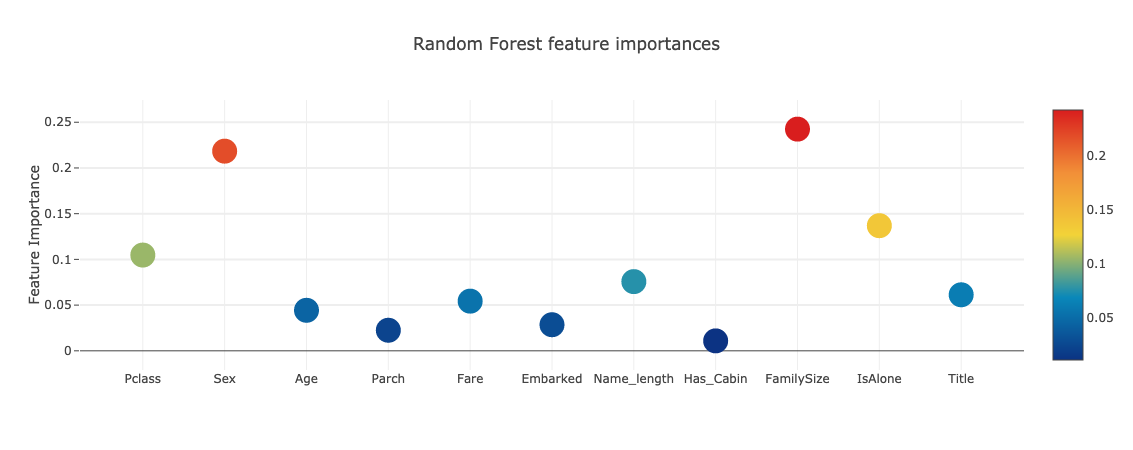

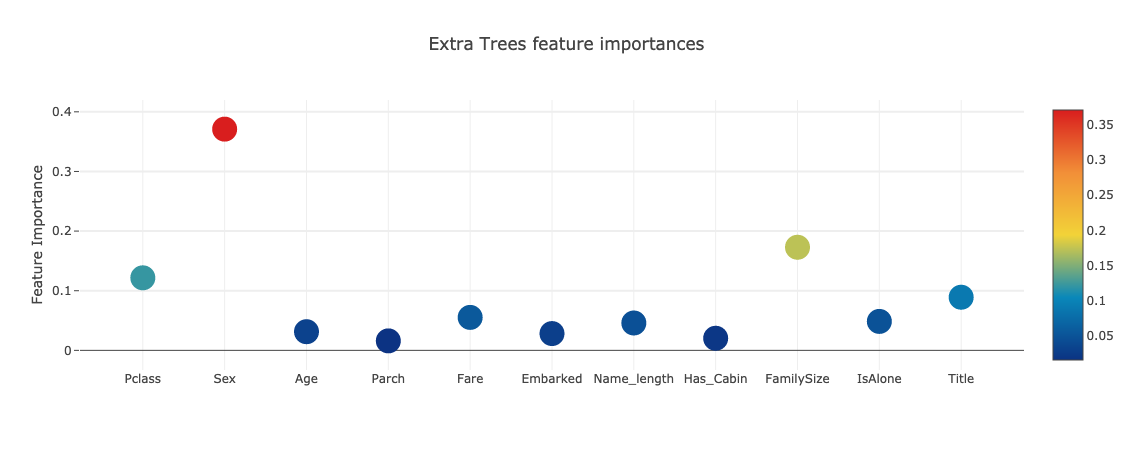

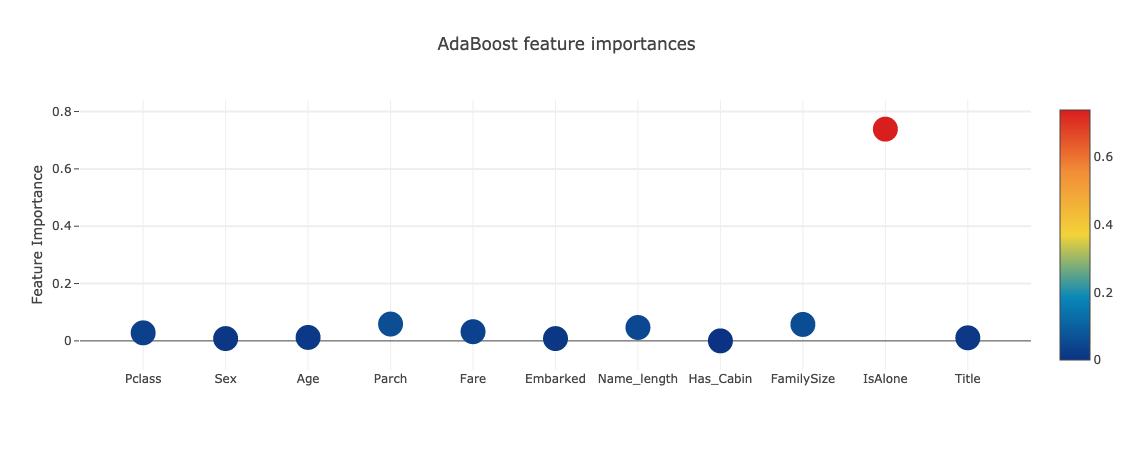

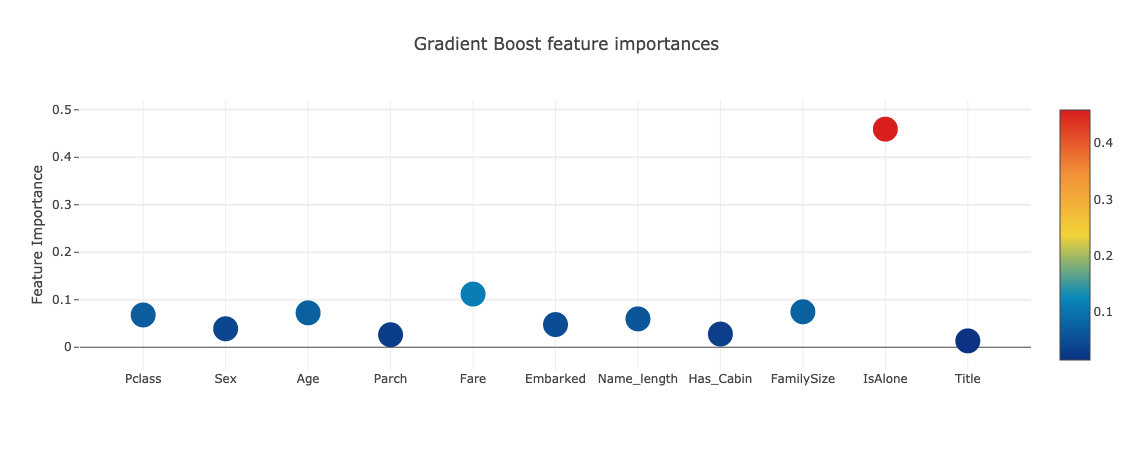

In [18]:
# Scatter plot
for name in feature_names:
    trace = go.Scatter(
        y=feature_dataframe[name].values,
        x=feature_dataframe['features'].values,
        mode='markers',
        marker=dict(
            sizemode='diameter',
            sizeref=1,
            size=25,
            color=feature_dataframe[name].values,
            colorscale='Portland',
            showscale=True
        ),
        text=feature_dataframe['features'].values
    )
    
    data = [trace]

    layout = go.Layout(
        autosize=True,
        title=name,
        hovermode='closest',
        yaxis=dict(
            title='Feature Importance',
            ticklen=5,
            gridwidth=2
        ),
        showlegend=False
    )

    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename='scatter2010')

In [19]:
# Create the new column containing the average of values
feature_dataframe['mean'] = feature_dataframe.mean(axis=1)

#### Plotly Barplot of Average Feature Importances

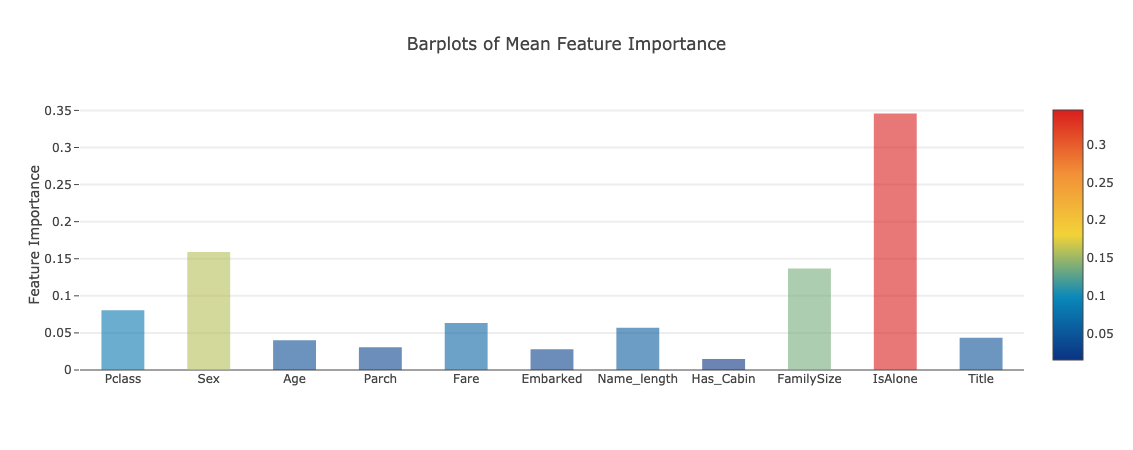

In [20]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
    x=x,
    y=y,
    width=0.5,
    marker=dict(
        color=feature_dataframe['mean'].values,
        colorscale='Portland',
        showscale=True,
        reversescale=False
    ),
    opacity=0.6
)]

layout = go.Layout(
    autosize=True,
    title='Barplots of Mean Feature Importance',
    hovermode='closest',
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

## Second-Level Predictions from the First-level Output

### First-level output as new features

In [21]:
base_predictions_train = pd.DataFrame({'RandomForest': rf_oof_train.ravel(),
                                       'ExtraTrees': et_oof_train.ravel(),
                                       'AdaBoost': ada_oof_train.ravel(),
                                       'GradientBoost': gb_oof_train.ravel()})
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


### Correlation Heatmap of the Second Level Training set

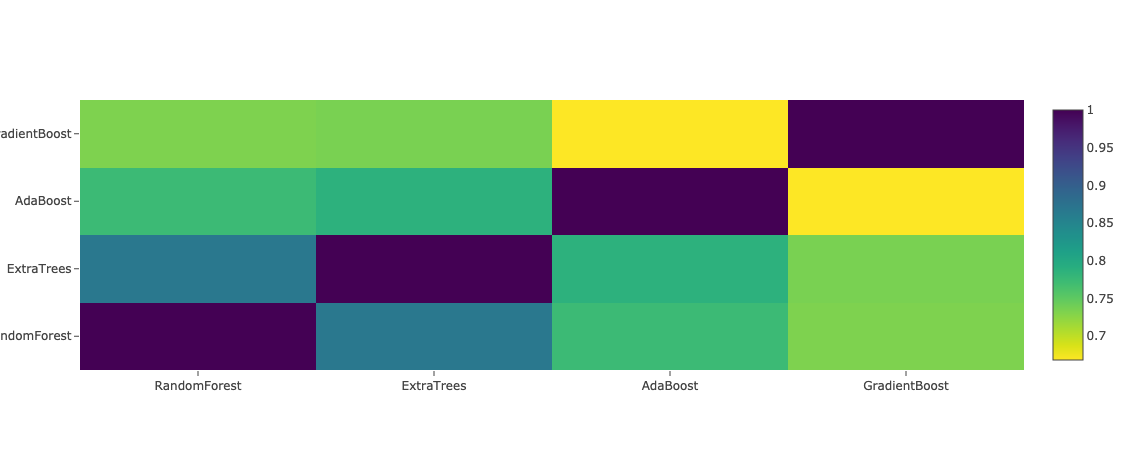

In [22]:
data = [
    go.Heatmap(
        z=base_predictions_train.astype(float).corr().values,
        x=base_predictions_train.columns.values,
        y=base_predictions_train.columns.values,
        colorscale='Viridis',
        showscale=True,
        reversescale=True
    )
]
py.iplot(data, filename='labelled-heatmap')

In [23]:
x_train = np.concatenate((et_oof_train, 
                          rf_oof_train, 
                          ada_oof_train,
                          gb_oof_train,
                          svc_oof_train), axis=1)
x_test = np.concatenate((et_oof_test,
                          rf_oof_test,
                          ada_oof_test,
                          gb_oof_test, 
                          svc_oof_test), axis=1)

### Second Level Learning Model via XGBoost

In [24]:
gbm = xgb.XGBClassifier(
    n_estimator=2000,
    max_depth=4,
    min_child_weight=2,
    gamma=0.9,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=-1,
    scale_pos_weight=1
    ).fit(x_train, y_train)

predictions = gbm.predict(x_test)

### Producing the Submission file

In [26]:
# Generate Submission File
output = pd.DataFrame({'PassengerId': passenger, 'Survived': predictions})
output.to_csv('../../data/stacking_ensemble_copied_features.csv', index=False)